## Accessing Sentinel-1 Level-1 GRD data with the Planetary Computer STAC API

The [Level-1 Ground Range Detected](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-1https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-1) (GRD) products in this Collection consist of focused SAR data that has been detected, multi-looked and projected to ground range using the Earth ellipsoid model WGS84.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

In [1]:
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import rich.table

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose an area and time of interest

We'll query for images over Microsoft's main campus in Redmond, Washington during January 2021.

In [3]:
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2021-01-01/2021-12-31"

search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 115 Items


We can use the `rendered_preview` asset to get a quick preview of the item. This uses the Planetary Computer's [data API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) to dynamically render an image from the underlying assets.

In [4]:
from IPython.display import Image

item = items[0]
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

The STAC metadata includes information about when and how the assets were acquired, including metadata from the [SAR](https://github.com/stac-extensions/sar) and [Satellite](https://github.com/stac-extensions/sat) extensions.

In [5]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                       │
│ datetime                              │ 2021-12-22T14:21:07.534562Z      │
│ end_datetime                          │ 2021-12-22 14:21:20.033489+00:00 │
│ platform                              │ SENTINEL-1B                      │
│ s1:datatake_id                        │ 235856                           │
│ s1:instrument_configuration_ID        │ 2                                │
│ s1:orbit_source                       │ RESORB                           │
│ s1:processing_level                   │ 1                                │
│ s1:product_timeliness                 │ Fast-24h                         │
│ s1:resolution                         │ high                             │
│ s1:shape                              │ [25981, 16680]                   │
│ s1:slice_number                       │ 9                                │
│ s1:total_slices                       │ 16                               │
│ sar:center_frequency                  │ 5.405                            │
│ sar:frequency_band                    │ C                                │
│ sar:instrument_mode                   │ IW                               │
│ sar:looks_azimuth                     │ 1                                │
│ sar:looks_equivalent_number           │ 4.4                              │
│ sar:looks_range                       │ 5                                │
│ sar:observation_direction             │ right                            │
│ sar:pixel_spacing_azimuth             │ 10                               │
│ sar:pixel_spacing_range               │ 10                               │
│ sar:polarizations                     │ ['VV', 'VH']                     │
│ sar:product_type                      │ GRD                              │
│ sar:resolution_azimuth                │ 22                               │
│ sar:resolution_range                  │ 20                               │
│ sat:absolute_orbit                    │ 30139                            │
│ sat:orbit_state                       │ descending                       │
│ sat:platform_international_designator │ 2016-025A                        │
│ sat:relative_orbit                    │ 13                               │
│ start_datetime                        │ 2021-12-22 14:20:55.035634+00:00 │
└───────────────────────────────────────┴──────────────────────────────────┘

The item's data assets will be some combination of `vh`, `vv`, `hv`, and `hh`, depending on the polarization the signal was transmitted and received in. In this case, the item has `vv` and `vh` assets.  In general, check the `sar:polarizations` field for what is avaiable.

In [6]:
item.properties["sar:polarizations"]

['VV', 'VH']

### Visualize the assets

Next, we'll use [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) to load the data. Since we're just vizualizing the data we'll load one of the lower-resolution overviews.

In [7]:
vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

We can plot this distribution of the pixel values, to get a sense for their range. The raw values are fairly skewed, so it's common to render with an amplitude scale (taking the square root of the value) or a dB scale ($10 \times log_{10}$  of the value).

In [8]:
import pandas as pd
import seaborn as sns

raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

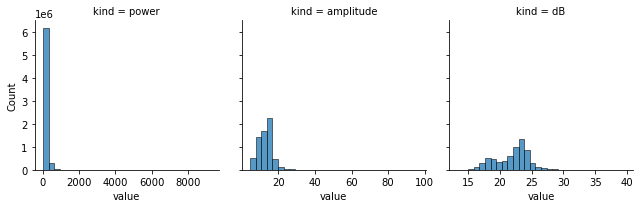

In [9]:
g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30);

Now let's recreate the false-color image from the data API, using a combination of the two bands. We'll use `vv` as the red band, `vh` as the green band, and `vv / vh` as the green band. We'll rescale it as well (using values from the [`mosaic/info`](https://planetarycomputer.microsoft.com/api/data/v1/docs#/PgSTAC%20Mosaic%20endpoints/map_mosaic_info_get) endpoint).

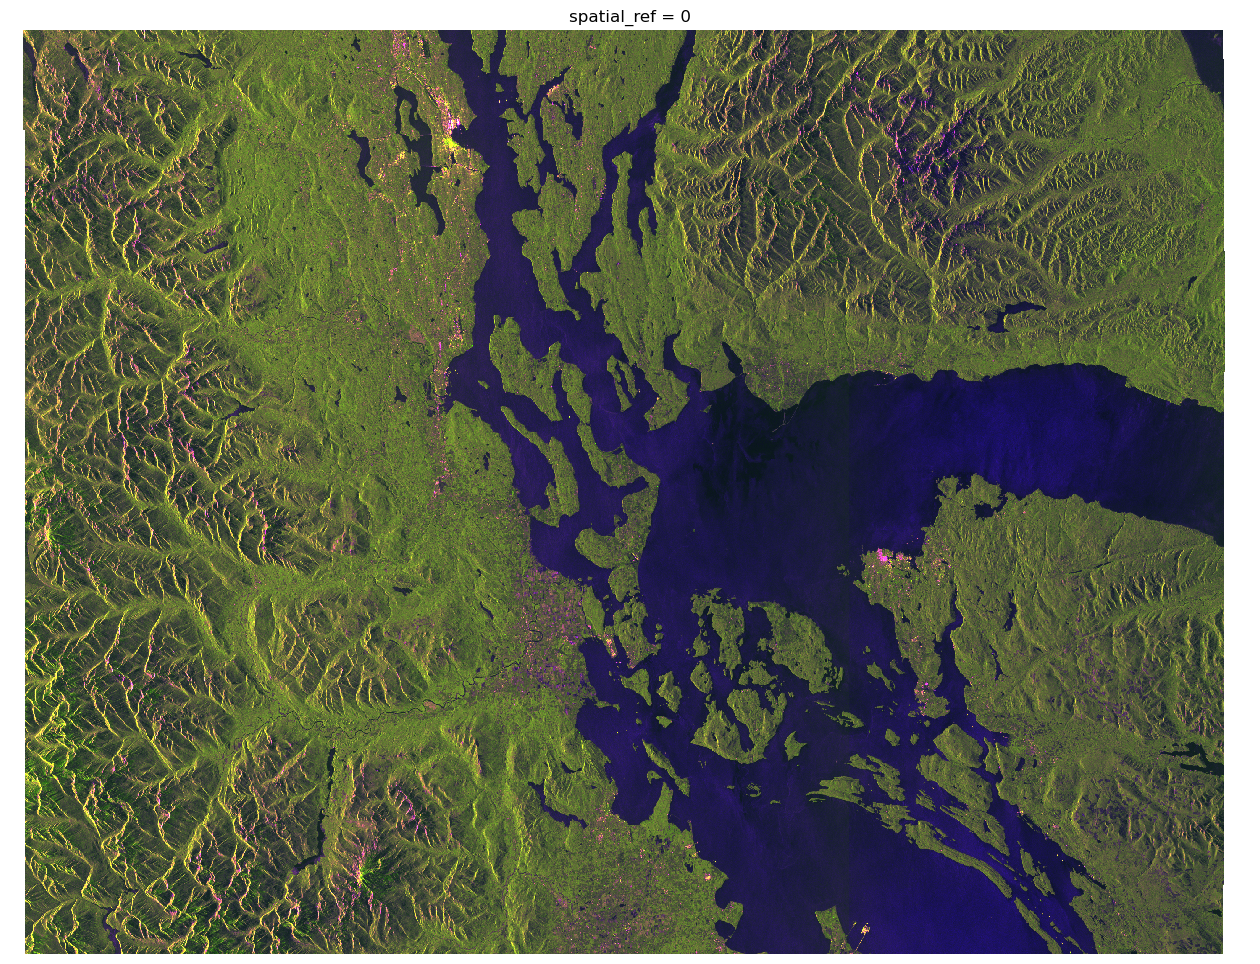

In [10]:
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()

By default, some Sentinel-1 GRD images may appear "upside-down". Seattle, the brightest spot area, appears towards the top-left of the image, despite being in the southwest of the area.

Whether the data needs to be flipped depends on the mode the satellite was in when the image was captured, which is available from the `sat:orbit_state` property in the STAC metadata.

In [11]:
item.properties["sat:orbit_state"]

'descending'

In this case, the satellite was in "descending" mode, and so we need to flip the image if we north to be up.

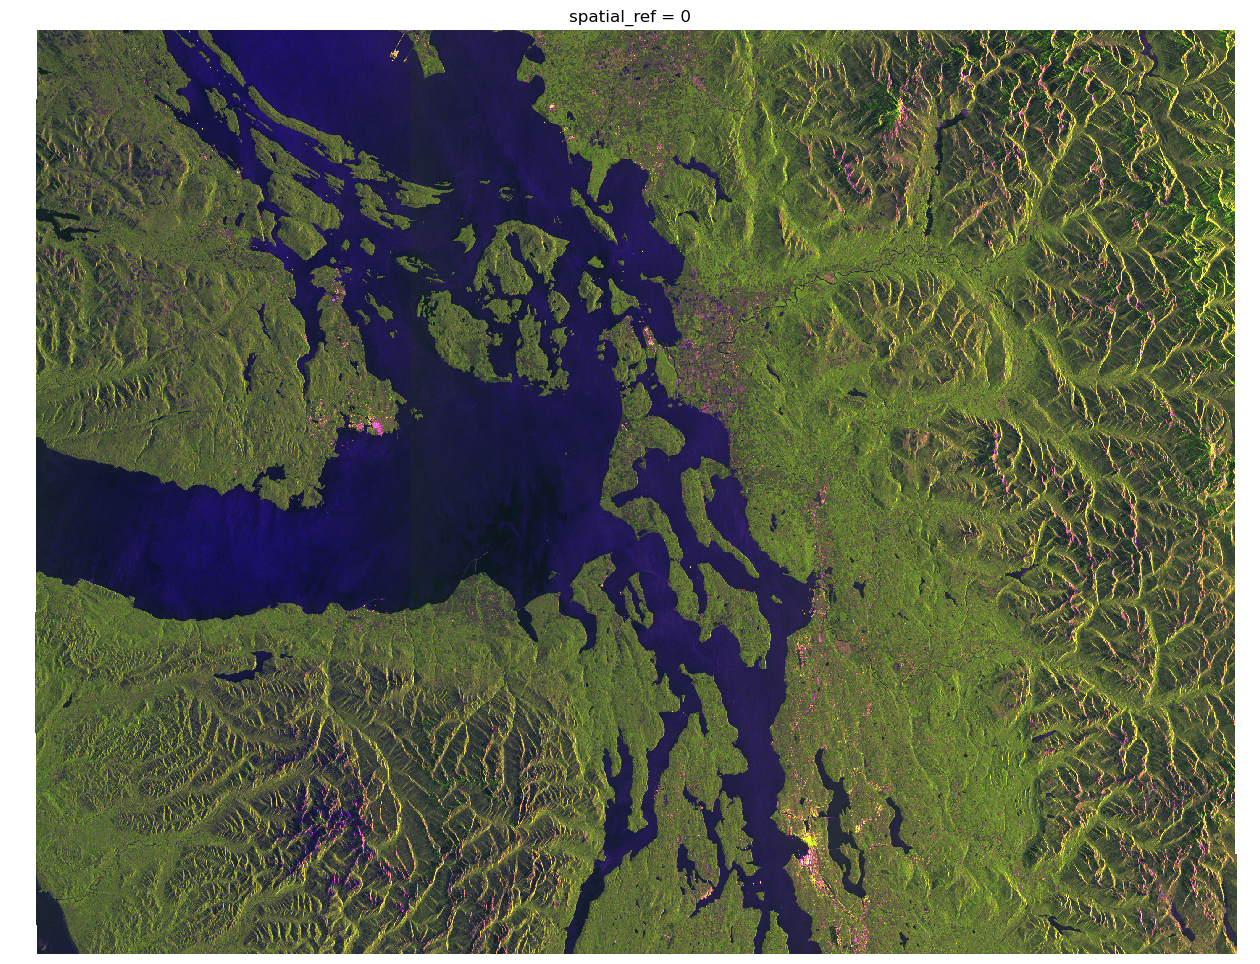

In [12]:
img = np.flip(data, axis=(1, 2)).clip(0, 1).plot.imshow(size=12)
img.axes.set_axis_off()

### GRD Products

The resolution and bands available depend on the [aquisition mode](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes) and level of multi-looking.

* Stripmap (SM)
* Interferometric Wide Swath (IW)
* Extra-Wide swath (EW)
* Wave (WV)

From the [Sentinel-1 User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes):

> The primary conflict-free modes are IW, with VV+VH polarisation over land, and WV, with VV polarisation, over open ocean. EW mode is primarily used for wide area coastal monitoring including ship traffic, oil spill and sea-ice monitoring. SM mode is only used for small islands and on request for extraordinary events such as emergency management.

You can query for specific modes using the `sar:instrument_mode` property.

In [13]:
search = catalog.search(
    collections=["sentinel-1-grd"],
    query={
        "sar:instrument_mode": {"eq": "SM"},
        "sar:polarizations": {"eq": ["VV", "VH"]},
    },
    limit=5,
)

gen = search.items()
item = next(gen)

Image(url=item.assets["rendered_preview"].href)

### Terrain Correction

Those wishing to use a terrain corrected Sentinel-1 product can use the pre-computed [Sentinel-1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) collection from the Planetary Computer, or apply their own [customizable terrain correction](https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/).